```
conda install -c conda-forge scikit-learn pandas
```

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

### Primera actividad de redes neuronales

In [20]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_data = cancer.data
y_data = cancer.target

(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)
- En el siguiente bloque explore la data, con el fin de responder a estas preguntas.
    - ¿De que se trata el dataset?
    - ¿Cuales son las clases de salida?
    - ¿A que corresponden las caracteristicas?
    - ¿Cuantas caracteristicas y clases de salida hay?
    - Etc.

El conjunto de datos de cáncer de mama de Wisconsin es un clásico conjunto de datos de clasificación binaria utilizado para diagnosticar tumores mamarios. Contiene características derivadas de imágenes digitales de muestras de tejido mamario y se utiliza para predecir si un tumor es maligno o benigno.

Clases de salida:
                0: Maligno (M)
                1: Benigno (B)

Caracteristicas:
                radius (mean of distances from center to points on the perimeter)
                texture (standard deviation of gray-scale values)
                perimeter
                area
                smoothness (local variation in radius lengths)
                compactness (perimeter^2 / area - 1.0)
                concavity (severity of concave portions of the contour)
                concave points (number of concave portions of the contour)
                symmetry
                fractal dimension ("coastline approximation" - 1)
                mean radius
                mean texture
                mean perimeter
                mean area
                mean smoothness
                mean compactness
                mean concavity
                mean concave points
                mean symmetry
                mean fractal dimension
                radius error
                texture error
                perimeter error
                area error
                smoothness error
                compactness error
                concavity error
                concave points error
                symmetry error
                fractal dimension error

Son 30 caracteristicas y 2 clases de salida, benigdo-maligno

In [21]:
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset

X = torch.tensor(X_data, dtype=torch.float32)
Y = torch.tensor(y_data,dtype=torch.long)

dataset = TensorDataset(X,Y)

train_set, valid_set,test_set = random_split(dataset,[342,113,114],generator=torch.Generator().manual_seed(1234)) ##No cambiar la semilla
train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

## Implentación de la Red Neuronal
- En el siguiente bloque implemente el modelo que utilizará su red neuronal para predecir si un paciente tiene cáncer o no, teniendo en cuenta sus caracteristicas.

In [30]:
import torch.nn as nn
import torch.optim as optim

# Definir el modelo de la red neuronal
class CancerNet(nn.Module):
    def __init__(self):
        super(CancerNet, self).__init__()
        self.fc1 = nn.Linear(30, 15)
        self.fc2 = nn.Linear(15, 2)  # 2 salidas para clasificación binaria
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

- En el siguiente bloque cree una instancia de su red neuronal definida anteriormente y defina una función de pérdida y optimizador adecuados:

In [31]:
# Crear una instancia del modelo
model = CancerNet()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Parametros Optimizador Adam:

- lr: Es la tasa de aprendizaje. 
- momentum: Podemos utilizar un valor mayor que cero para evitar estancamiento en mínimos locales
- weight_decay: Podemos utilizar un valor mayor que cero para evitar sobreajuste

- Responda: 
    - ¿Porqué eligió esa función de pérdida?
        - CroosEntropyLoss es una de las funciones mas utilizadas para clasificacion con C clases
    - Elija 2 optimizadores populares y describalos, luego explique porqué elige uno de los 2.
        - En el cuadernillo se menciona que los mas populares son Adam (gradiente descendente con tasa de aprendizaje) y SGD (gradiente descendente estotastico)
            Se va a trabajar con el optimizador Adam debido a su capacidad de manejar la taza de aprendizaje.

- En el siguiente bloque programe el entrenamiento de su red neuronal

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Crear DataLoader para el conjunto de entrenamiento
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [41]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=50):
    for epoch in range(num_epochs):  # Número de épocas
        model.train()  # Modo entrenamiento
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        
        epoch_loss = running_loss / len(train_loader.dataset)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Llamar a la función de entrenamiento
train_model(model, criterion, optimizer, train_loader)

Epoch [10/50], Loss: 0.0006
Epoch [20/50], Loss: 0.0005
Epoch [30/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0002


- En el sigueinte bloque muestre el gráfico de entrenamiento y validación.
- ¿El entrenamiento de su red neuronal está "listo"?

- En el siguiente bloque evalue que tan bueno es su modelo mediante diferentes métricas

In [47]:
# Evaluar el modelo en el conjunto de prueba
def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()  # Modo evaluación
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# Convertir el modelo y datos de prueba a CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Evaluar el modelo
evaluate_model(model, X_test_tensor, y_test_tensor)


Precisión en el conjunto de prueba: 0.9737


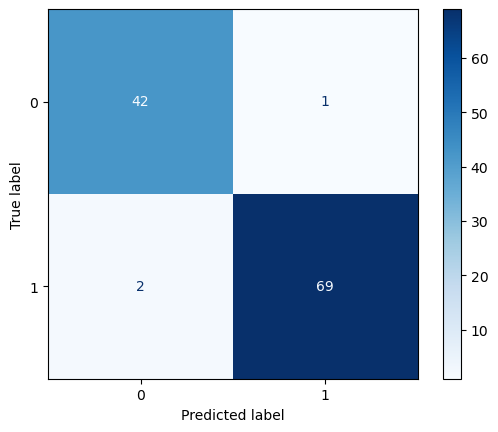

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hacer predicciones con el modelo entrenado
model.eval()  # Modo evaluación
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_tensor, dim=1).numpy()

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

- Concluya sobre su trabajo.  
- Responda
    - ¿Qué tan confiable sería su modelo en un entorno clínico? 
        Habria que analizar el proceso clinico que se esta tratando, tiene 1 error en cada clase 
    - ¿Qué haría para mejorarlo?
        - Recoger datos más diversos y extensos para entrenar el modelo
        - ajuste de hiperparámetros, ingeniería de características o usar diferentes arquitecturas de modelos.
    - Sobre la matriz de confusión, ¿Alguno de sus elementos son más importantes que otros en este caso?
    Falsos Negativos (FN): Podrían significar un diagnóstico perdido, lo que podría retrasar el tratamiento y empeorar los resultados para el paciente. En muchos escenarios clínicos, minimizar los FN es crucial.
    Falsos Positivos (FP): Podrían llevar a pruebas o tratamientos adicionales innecesarios, causando ansiedad, costos aumentados y posibles efectos secundarios.
    ¿Que significaría el aumento de FN o FP en este caso? 
    Aumento en FN: Más pacientes con la condición podrían no ser diagnosticados, lo que podría llevar a serias consecuencias para la salud.
    Aumento en FP: Más pacientes sin la condición podrían someterse a pruebas o tratamientos adicionales innecesarios, lo que puede llevar a angustia psicológica y gastos médicos innecesarios.
- Investigue sobre alguna arquitectura de red neuronal distinta a la utilizada en este trabajo, describala y explique en que casos sería útil.



### Pregunta Bonus
- ¿Cúal es la principal limitación de las redes neuronales comparado al cerebro humano?

Puede ser la comprension sentimental respecto a los resultados, el caso de estudio es un tema delicado para la vida personal de cada persona, debe tratarse con cuidado y respeto